# LSTM using Keras through Theano

Using the Bitcoin series with a memory of the last 100 trading days as inputs to the recurrent net. The 100 has been zero padded for the earlier times, up until a threshold of 50 or so for the smaller sequences. 

* Remember to discuss zero padding for variable length inputs in my paper

In [157]:
% matplotlib inline

# imports...

import pandas as pd  
from random import random
import numpy as np
from keras.models import Sequential  
from keras.layers.core import Dense, Activation  
from keras.layers.recurrent import LSTM

import matplotlib.pyplot as plt

Now we are going to generate the data that is needed for the LSTM model... (and view it)

In [168]:
#flow = (list(range(1,10,1)) + list(range(10,1,-1)))*50  
#pdata = pd.DataFrame({"a":flow, "b":flow, "c":flow})  
#pdata.b = pdata.b.shift(9)  
#data = pdata.iloc[10:] * random()  # some noise  
#print(data)



In [306]:
# BUT we really want to use BITCOIN data or CS:GO data...

# so import the BTC data as data...

data = pd.read_csv('btc3.csv')
#print(data)
#data.ix[:,2] = pd.to_numeric(data.ix[:,2], errors = 0)
#print(data.ix[:,2])
print(data)

      Weighted Price    volatility
0         103.658462  2.208810e-04
1         108.130987  1.784375e-03
2         111.317999  8.437650e-04
3         107.814826  1.022451e-03
4         108.524293  4.301880e-05
5         111.548353  7.553760e-04
6         112.107655  2.501450e-05
7         116.827849  1.700891e-03
8         118.491728  1.999870e-04
9         118.654391  1.881940e-06
10        122.798379  1.178469e-03
11        129.216287  2.595274e-03
12        130.084655  4.486030e-05
13        130.570896  1.391970e-05
14        129.435375  7.629360e-05
15        124.344992  1.609761e-03
16        121.964314  3.737030e-04
17        120.425598  1.611980e-04
18        118.798701  1.850050e-04
19        118.425813  9.883190e-06
20        119.449318  7.405380e-05
21        122.802264  7.663640e-04
22        122.878296  3.830920e-07
23        126.908950  1.041708e-03
24        127.623010  3.148090e-05
25        125.302859  3.366120e-04
26        124.617007  3.012460e-05
27        125.832624

... And define some random functions for turing data into our train and test sets and X's and Y's:

In [297]:

'''
The model architecture is made to pull in 
'''

def _load_data(data, n_prev = 50):  
    """
    data should be pd.DataFrame()
    """

    docX, docY = [], []
    for i in range(len(data)-n_prev):
        docX.append(data.iloc[i:i+n_prev].as_matrix())
        docY.append(data.iloc[i+n_prev].as_matrix())
    alsX = np.array(docX)
    alsY = np.array(docY)

    return alsX, alsY

def train_test_split(df, test_size=0.1):  
    """
    This just splits data to training and testing parts
    """
    ntrn = round(len(df) * (1 - test_size))

    X_train, y_train = _load_data(df.iloc[0:ntrn])
    X_test, y_test = _load_data(df.iloc[ntrn:])
    

    return (X_train, y_train[:,2]), (X_test, y_test[:,2])


In [307]:
(X_train, y_train), (X_test, y_test) = train_test_split(data)
#y_train = pd.DataFrame(y_train)
#y_test = pd.DataFrame(y_test)
y_train = y_train.astype(float)
ytest = y_test.astype(float)
X_train = X_train.astype(float)
X_test = X_test.astype(float)

print('X_train has shape: ',np.shape(X_train)  )
print('y_train has shape: ', np.shape(y_train))
#print(y_train)
#print(X_test)
#print('y_train has shape: ',np.shape( np.reshape(y_train,(len(y_train),1)) ))
#print('X_test has shape: ', np.shape(X_test) )
#print('y_test has shape: ', np.shape(y_test) )
#print()
#print('We can see that the X-inputs have: size = (samples, timesteps, var_#)')
#print('While the y-outputs have: size = (samples, output_dim)')

IndexError: index 2 is out of bounds for axis 1 with size 2

In [343]:
## SAVE DATA AS CSVs

#print(X_train[:,:,2]) # this coincides with the volatility series only...

X1 = pd.DataFrame(X_train[:,:,2])
X2 = pd.DataFrame(X_test[:,:,2])
Y1 = pd.DataFrame(y_train)
Y2 = pd.DataFrame(y_test)

X1.to_csv('X1.csv')
X2.to_csv('X2.csv')
Y1.to_csv('Y1.csv')
Y2.to_csv('Y2.csv')
print(Y1)



            0
0    0.001907
1    0.000371
2    0.000694
3    0.000434
4    0.006607
5    0.024142
6    0.010922
7    0.010834
8    0.000495
9    0.031276
10   0.143859
11   0.002128
12   0.059622
13   0.084395
14   0.021187
15   0.045625
16   0.019796
17   0.003673
18   0.019640
19   0.015693
20   0.011328
21   0.000298
22   0.000162
23   0.001868
24   0.000976
25   0.001918
26   0.066901
27   0.094879
28   0.074272
29   0.167592
..        ...
970  0.000205
971  0.000008
972  0.008420
973  0.117330
974  0.081923
975  0.003341
976  0.000283
977  0.090336
978  0.000007
979  0.006317
980  0.000016
981  0.004579
982  0.146559
983  0.051246
984  0.097132
985  0.176441
986  0.005004
987  0.048749
988  0.003597
989  0.002591
990  0.008829
991  0.019447
992  0.014107
993  0.010448
994  0.016311
995  0.000035
996  0.000327
997  0.000003
998  0.049337
999  0.004767

[1000 rows x 1 columns]


### Define the LSTM Architecture

In [335]:
in_neurons = np.shape(X_train)[2]   
out_neurons = 1 # since regression output  
hidden_neurons = 2

model = Sequential()  
model.add(LSTM(output_dim=hidden_neurons, input_dim=in_neurons, return_sequences=False)) 
model.add(Dense(output_dim=out_neurons, input_dim=hidden_neurons))
model.add(Activation("linear"))  
model.compile(loss="mean_squared_error", optimizer= 'rmsprop' )  


### Train the Model

In [336]:
#(X_train, y_train), (X_test, y_test) = train_test_split(data)  # retrieve data
model.fit(X_train, y_train, batch_size=1, nb_epoch=1, validation_split=0.05)  

predicted = model.predict(X_test)  
rmse = np.sqrt(((predicted - y_test) ** 2).mean(axis=0))

# and maybe plot it
#pd.DataFrame(predicted[:100]).to_csv("predicted.csv")  
#pd.DataFrame(y_test[:100]).plot("test_data.csv")  

Train on 950 samples, validate on 50 samples
Epoch 1/1
950/950 [==============================] - 109s - loss: 0.0097 - acc: 0.0011 - val_loss: 0.0021 - val_acc: 0.0000e+00


## AYYY FINNA PLOT DIS RESULTS N SHIIET... 
Turn up
### SKKRT!!!

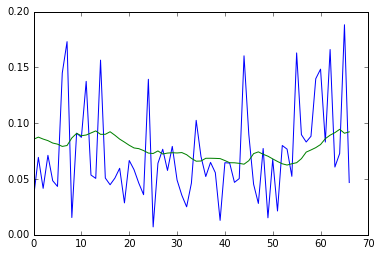

In [262]:
fig, ax = plt.subplots()

ax.plot(pd.DataFrame(y_test))
ax.plot(pd.DataFrame(predicted))

# need to write a dataframe of y_test and X_test in order to test other models on it




#pd.DataFrame(predicted).plot()  

'\nHIDDEN UNITS = 2...\nBATCH SIZE = 1...\nTrain on 950 samples, validate on 50 samples\nEpoch 2/1\n950/950 [==============================] - 101s - loss: 0.0058 - acc: 0.0011 - val_loss: 0.0015 - val_acc: 0.0000e+00\n'

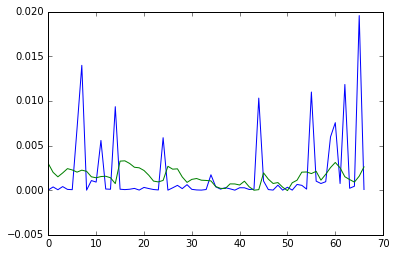

In [318]:
# FIG 2

fig, ax = plt.subplots()

ax.plot(pd.DataFrame(y_test))
ax.plot(pd.DataFrame(predicted))
fig2_rmse = rmse
## error
'''
HIDDEN UNITS = 2...
BATCH SIZE = 1...
Train on 950 samples, validate on 50 samples
Epoch 2/1
950/950 [==============================] - 101s - loss: 0.0058 - acc: 0.0011 - val_loss: 0.0015 - val_acc: 0.0000e+00
'''

'\nHIDDEN UNITS = 5...\nBATCH SIZE = 1...\nTrain on 950 samples, validate on 50 samples\nEpoch 2/2\n950/950 [==============================] - 102s - loss: 0.0047 - acc: 0.0011 - val_loss: 0.0016 - val_acc: 0.0000e+00'

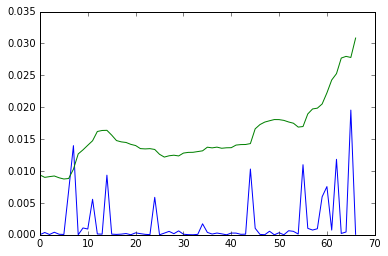

In [325]:
# FIG 3

fig, ax = plt.subplots()

ax.plot(pd.DataFrame(y_test))
ax.plot(pd.DataFrame(predicted))
fig3_rmse = rmse
## error
'''
HIDDEN UNITS = 5...
BATCH SIZE = 1...
Train on 950 samples, validate on 50 samples
Epoch 1/1
950/950 [==============================] - 79s - loss: 0.0078 - acc: 0.0011 - val_loss: 0.0015 - val_acc: 0.0000e+00
'''

'\nHIDDEN UNITS = 10...\nBATCH SIZE = 1...\nTrain on 950 samples, validate on 50 samples\nEpoch 1/1\n950/950 [==============================] - 136s - loss: 0.0059 - acc: 0.0011 - val_loss: 0.0016 - val_acc: 0.0000e+00\n'

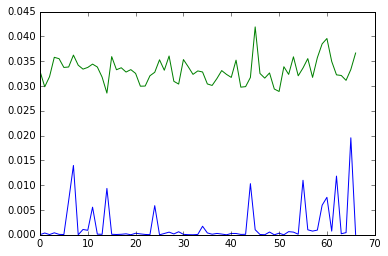

In [330]:
# FIG 4

fig, ax = plt.subplots()

ax.plot(pd.DataFrame(y_test))
ax.plot(pd.DataFrame(predicted))
fig4_rmse = rmse
## error
'''
HIDDEN UNITS = 10...
BATCH SIZE = 1...
Train on 950 samples, validate on 50 samples
Epoch 1/1
950/950 [==============================] - 136s - loss: 0.0059 - acc: 0.0011 - val_loss: 0.0016 - val_acc: 0.0000e+00
'''

'\nHIDDEN UNITS = 2...\nBATCH SIZE = 1...\nADAM, and MSE Logarithmic...\n'

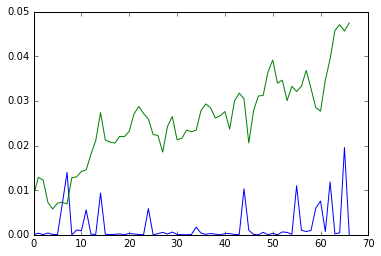

In [334]:
# FIG 5

fig, ax = plt.subplots()

ax.plot(pd.DataFrame(y_test))
ax.plot(pd.DataFrame(predicted))
fig4_rmse = rmse
## error
'''
HIDDEN UNITS = 2...
BATCH SIZE = 1...
ADAM, and MSE Logarithmic...
Train on 950 samples, validate on 50 samples
Epoch 1/1
950/950 [==============================] - 107s - loss: 0.0124 - acc: 0.0021 - val_loss: 0.0016 - val_acc: 0.0000e+00

'''

'\nHIDDEN UNITS = 2...\nBATCH SIZE = 1...\nADAM, and MSE ...\nTrain on 950 samples, validate on 50 samples\nEpoch 1/1\n950/950 [==============================] - 109s - loss: 0.0097 - acc: 0.0011 - val_loss: 0.0021 - val_acc: 0.0000e+00\n'

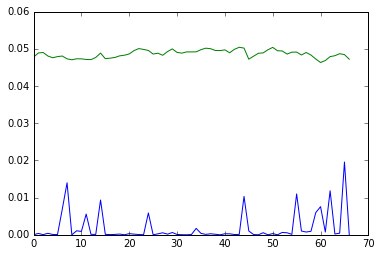

In [337]:
# FIG 6

fig, ax = plt.subplots()

ax.plot(pd.DataFrame(y_test))
ax.plot(pd.DataFrame(predicted))
fig4_rmse = rmse
## error
'''
HIDDEN UNITS = 2...
BATCH SIZE = 1...
ADAM, and MSE ...
Train on 950 samples, validate on 50 samples
Epoch 1/1
950/950 [==============================] - 109s - loss: 0.0097 - acc: 0.0011 - val_loss: 0.0021 - val_acc: 0.0000e+00
'''

In [345]:
np.sum(fig2_rmse)/len(fig2_rmse)

# figure 2's RMSE is...

0.0026312929848122048

In [346]:
np.sum(fig3_rmse)/len(fig3_rmse)

0.014696703567928487